In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_sample_submission.csv
/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv
/kaggle/input/rsna-pneumonia-detection-challenge/GCP Credits Request Link - RSNA.txt
/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv
/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/c3b05294-29be-46e4-8a51-96fd211e4ca5.dcm
/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/6a6ed2c5-d179-4c19-aac7-0d70eb87e024.dcm
/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/06550cfd-e9d5-415e-bae9-3146329ed9e6.dcm
/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/ef9eee29-6bdd-41da-ae40-9473592a9d5c.dcm
/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/c5dfc1a7-4669-42ce-af9f-62c3d8322049.dcm
/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/791e72c5-ecb4-43bc-aeda-7756af052534.dcm
/kaggle/input/r

In [2]:
#importing required libraries

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from tensorflow.keras.optimizers import Adam 

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np
import pandas as pd

import plotly.graph_objs as go

In [3]:
train_labels_df = pd.read_csv("../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")

In [4]:
class_info = pd.read_csv("../input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv")

In [5]:
train_labels_df.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [6]:
class_info.head()

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [7]:
# checking shape
class_info.shape

(30227, 2)

In [8]:
#checking no. of unique values in patientId column
len(np.unique(class_info['patientId']))

26684

**Exploring the data**

In [9]:
def count_missing_data(data_df):
    total = data_df.isnull().sum().sort_values(ascending = False)
    percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [10]:
count_missing_data(train_labels_df)

Total    Percent
x          20672  68.389188
y          20672  68.389188
width      20672  68.389188
height     20672  68.389188
patientId      0   0.000000
Target         0   0.000000

In [11]:
count_missing_data(class_info)

Total  Percent
patientId      0      0.0
class          0      0.0

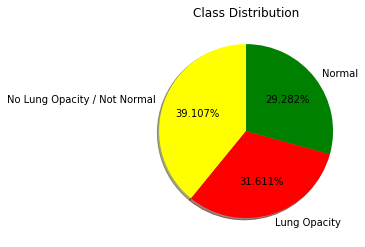

In [12]:
# Class distribution

class_details=class_info["class"].value_counts()

labels = (np.array(class_details.index))
sizes = (np.array((class_details / class_details.sum())*100))
colors = ['yellow', 'red','green']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.3f%%', shadow=True, startangle=90)
plt.title("Class Distribution")
plt.show()

In [13]:
train_class_df = train_labels_df.merge(class_info, left_on='patientId', right_on='patientId', how='inner')
train_class_df.sample(10)

patientId      x      y  width  height  \
32666  ea3f3fb8-d6dc-41c8-9bdf-a67b43570477  311.0  559.0  145.0   110.0   
36083  051c2709-fbbf-408f-aa19-c869e16a79e2  544.0  340.0  249.0   448.0   
9577   55754887-a552-47dd-a5c6-2d069da40136  172.0  146.0  197.0   527.0   
22223  aaef0613-d604-42d9-a13e-dd6f146b15cc    NaN    NaN    NaN     NaN   
11425  6367e27d-7360-41ad-9410-242939c0f29b    NaN    NaN    NaN     NaN   
26967  bfdbe64f-1ab9-4b72-a4b5-3ef6a057add2    NaN    NaN    NaN     NaN   
2232   17c749dc-e97a-4c5c-b4f4-c68b135a1a64  219.0  419.0  220.0   264.0   
2922   29b0895a-a35b-4681-9706-71bf3c50f857  596.0  398.0  145.0   334.0   
23673  b1827a4d-c98c-4719-8296-1659617870a7    NaN    NaN    NaN     NaN   
26670  beaee8dc-2b30-41c5-b646-b6f602b965a7  548.0  351.0  217.0   252.0   

       Target                         class  
32666       1                  Lung Opacity  
36083       1                  Lung Opacity  
9577        1                  Lung Opacity  
22223       0                        Normal  
11425       0  No Lung Opacity / Not Normal  
26967       0                        Normal  
2232        1                  Lung Opacity  
2922        1                  Lung Opacity  
23673       0                        Normal  
26670       1                  Lung Opacity

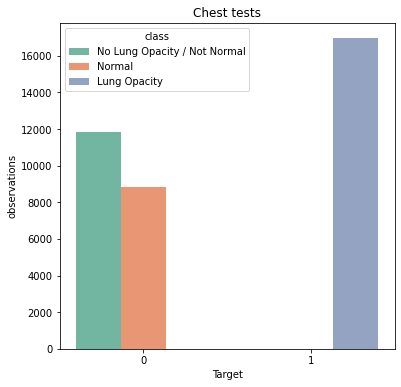

In [14]:
# plotting the number of observations for each class detected, grouped by Target value.
fig, ax = plt.subplots(nrows=1,figsize=(6,6))
tmp = train_class_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'observations': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='observations',hue='class',data=df, palette='Set2')
plt.title("Chest tests")
plt.show()

Here, we can observe that all observations with Target =1 where the disease is detected is associated with the Class Lung Opacity. The observations with Target = 0 disease is not detected are either of Class: Normal or Class: No Lung Opacity / Not Normal.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

<Figure size 432x288 with 0 Axes>

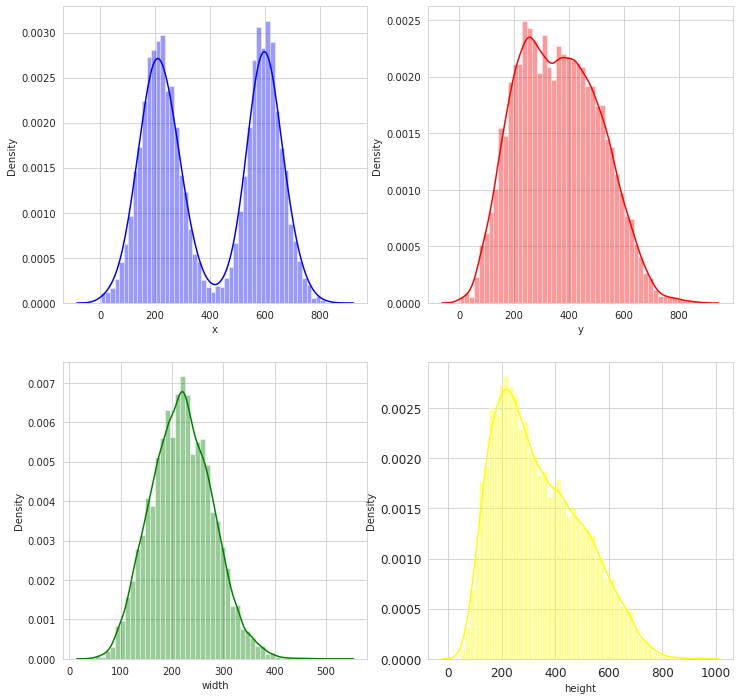

In [15]:
# For the class Lung Opacity(Target = 1), plotting the density of x, y, width and height.
T_1 = train_class_df[train_class_df['Target']==1]
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.distplot(T_1['x'],kde=True,bins=50, color="blue", ax=ax[0,0])
sns.distplot(T_1['y'],kde=True,bins=50, color="red", ax=ax[0,1])
sns.distplot(T_1['width'],kde=True,bins=50, color="green", ax=ax[1,0])
sns.distplot(T_1['height'],kde=True,bins=50, color="yellow", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0.98, 'Pneumonia location')

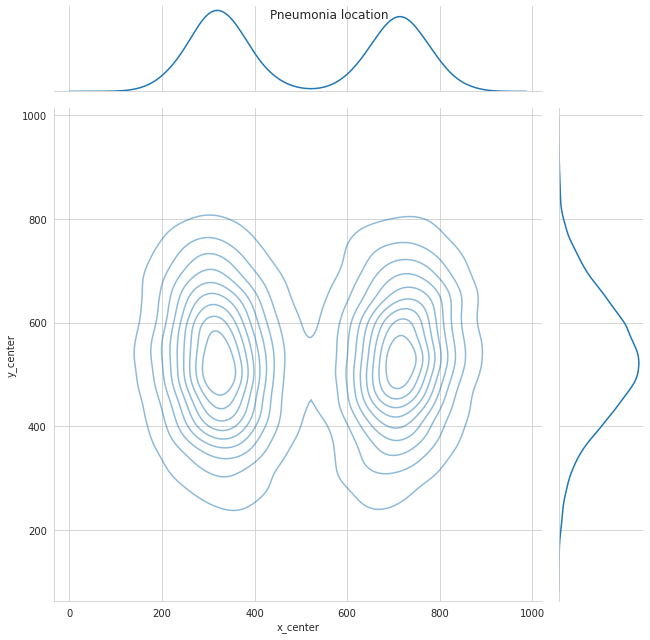

In [16]:
# checking Pneumonia location 
train_class_df['x_center']=train_class_df['x'] + train_class_df['width']/2
train_class_df['y_center']=train_class_df['y'] + train_class_df['height']/2
# Plot x and y centers
sns.jointplot("x_center", "y_center",kind="kde", data=train_class_df, height=9, alpha=0.5)
plt.suptitle('Pneumonia location')

**Image data**

In [17]:
IS_LOCAL = True
import os
if(IS_LOCAL):
    PATH="../input/rsna-pneumonia-detection-challenge"
else:
    PATH="../input/"
print(os.listdir(PATH))

['stage_2_train_images', 'stage_2_sample_submission.csv', 'stage_2_detailed_class_info.csv', 'GCP Credits Request Link - RSNA.txt', 'stage_2_train_labels.csv', 'stage_2_test_images']


In [18]:
image_path = os.listdir(PATH+'/stage_2_train_images')[:5]
print(image_path)

['c3b05294-29be-46e4-8a51-96fd211e4ca5.dcm', '6a6ed2c5-d179-4c19-aac7-0d70eb87e024.dcm', '06550cfd-e9d5-415e-bae9-3146329ed9e6.dcm', 'ef9eee29-6bdd-41da-ae40-9473592a9d5c.dcm', 'c5dfc1a7-4669-42ce-af9f-62c3d8322049.dcm']


In [19]:
train_images = os.listdir(PATH+'/stage_2_train_images')
test_images = os.listdir(PATH+'/stage_2_test_images')

In [20]:
# Checking lengths of train images and test images
print("Number of images in training data =", len(train_images),
      "\n Number of images in training data =", len(test_images))

Number of images in training data = 26684 
 Number of images in training data = 3000


In [21]:
train_class_df.shape

(37629, 9)

In [22]:
# No.of unique records in training data
print("Unique patient_Id in  train_class_df: ", train_class_df['patientId'].nunique()) 

Unique patient_Id in  train_class_df:  26684


Since there is difference in no. of records in train_class_df and Unique patient_Id, the data seems to have some duplicate values.

In [23]:
df_m = train_class_df.groupby(['patientId','Target', 'class'])['patientId'].count()
df = pd.DataFrame(data={'Observations': df_m.values}, index=df_m.index).reset_index()
df_m = df.groupby(['Observations','Target','class']).count()
df_n = pd.DataFrame(data=df_m.values, index=df_m.index).reset_index()
df_n.columns = ['Observations', 'Target','Class', 'Entries']
df_n

Observations  Target                         Class  Entries
0             1       0  No Lung Opacity / Not Normal    11821
1             1       0                        Normal     8851
2             1       1                  Lung Opacity     2614
3             4       1                  Lung Opacity     3266
4             9       1                  Lung Opacity      119
5            16       1                  Lung Opacity       13

In [24]:
import pydicom as dcm
one_img =list(train_class_df[:3].T.to_dict().values())[0]['patientId']
one_img = one_img+'.dcm'
dicom_file_path = os.path.join(PATH,"stage_2_train_images/",one_img)
dicom_dataset = dcm.read_file(dicom_file_path)
dicom_dataset

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [25]:
def show_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(4,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()

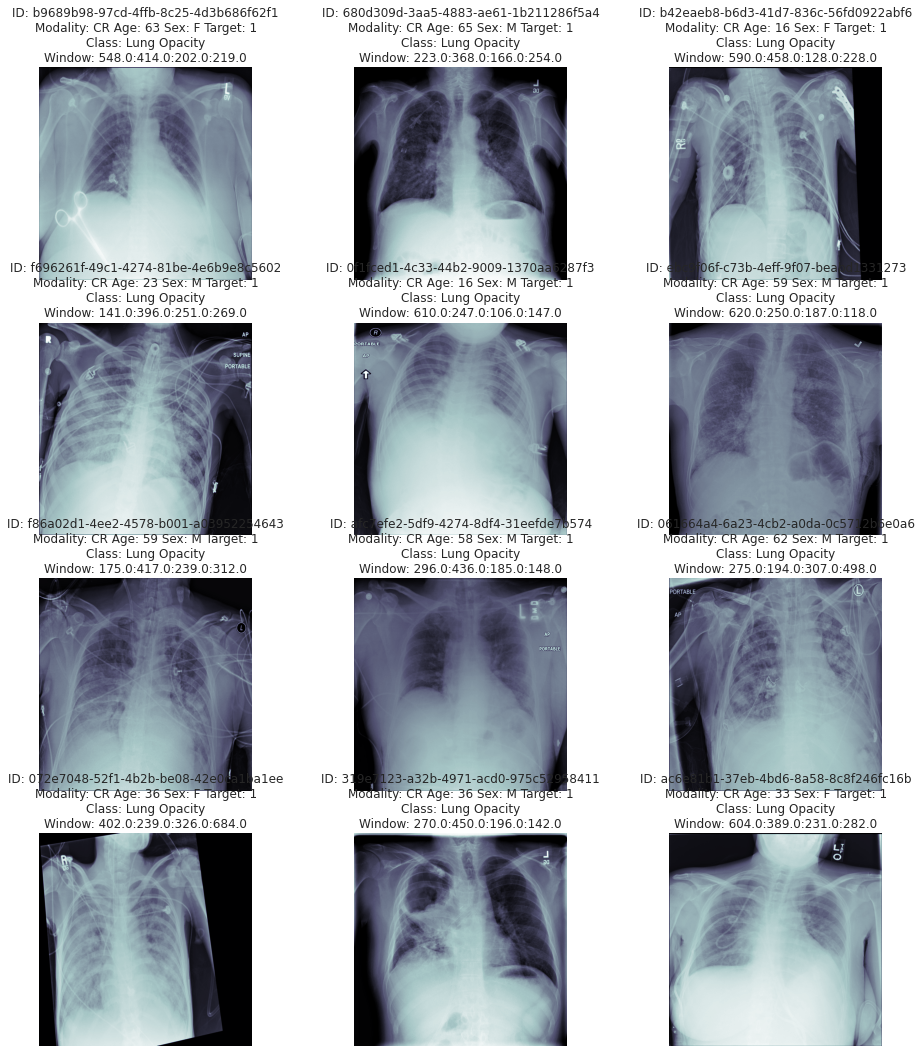

In [26]:
show_images(train_class_df[train_class_df['Target']==1].sample(12))

**target = 1**

In [27]:
from matplotlib.patches import Rectangle

def show_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(2,2, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//2, i%2].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//2, i%2].axis('off')
        ax[i//2, i%2].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], data_row['class']))
        rows = train_class_df[train_class_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//2, i%2].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'],
                        color = "red",alpha = 0.1))   
    plt.show()

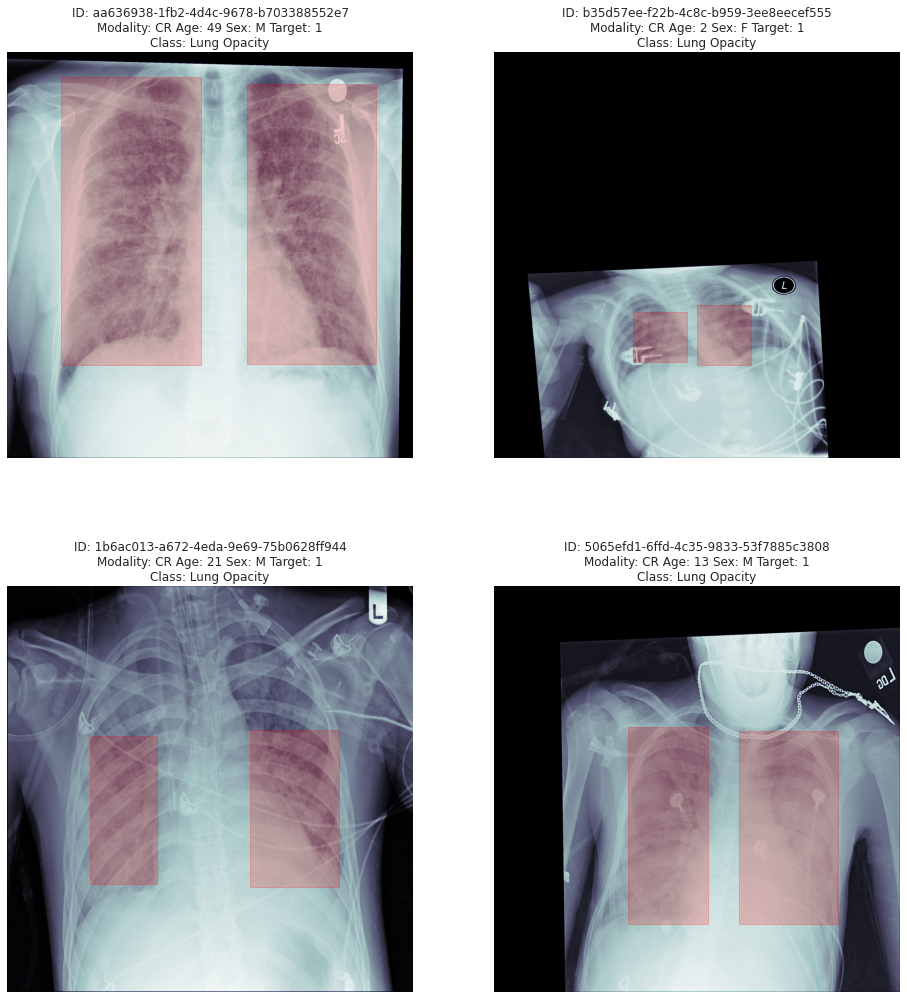

In [28]:
show_images_with_boxes(train_class_df[train_class_df['Target']==1].sample(4))

**target=0**

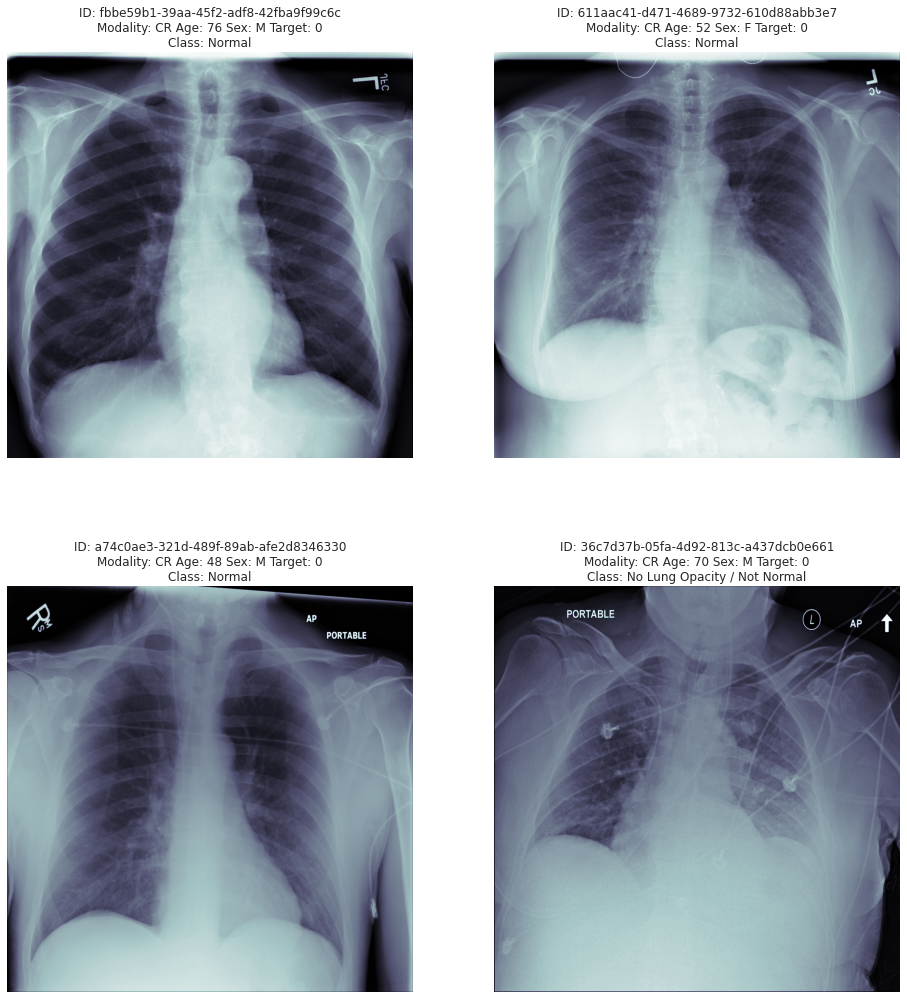

In [29]:
show_images_with_boxes(train_class_df[train_class_df['Target']==0].sample(4))

### Model Building

In [30]:
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

sns.set_style('whitegrid')
np.warnings.filterwarnings('ignore')

In [31]:
#Attaining our Training & Testing Data in Proper Format

def readDicomData(data):
    
    res = []
    
    for filePath in tqdm(data): # Loop over data
        
        # We use stop_before_pixels to avoid reading the image (Saves on speed/memory)
        f = dcm.read_file(filePath, stop_before_pixels=True)
        res.append(f)
    
    return res

In [32]:
import glob

trainImagesPath = "../input/rsna-pneumonia-detection-challenge/stage_2_train_images"
testImagesPath = "../input/rsna-pneumonia-detection-challenge/stage_2_test_images"

# Get an array of the test & training file paths
trainFilepaths = glob.glob(f"{trainImagesPath}/*.dcm")
testFilepaths = glob.glob(f"{testImagesPath}/*.dcm")

# Read data into an array
trainImages = readDicomData(trainFilepaths[:5000])
testImages = readDicomData(testFilepaths)

100%|██████████| 3000/3000 [00:29<00:00, 101.81it/s]


In [33]:
# balancing data

COUNT_NORMAL = len(train_labels_df.loc[train_labels_df['Target'] == 0]) # Number of patients with no pneumonia
COUNT_PNE = len(train_labels_df.loc[train_labels_df['Target'] == 1]) # Number of patients with pneumonia
TRAIN_IMG_COUNT = len(trainFilepaths) # Total patients

# We calculate the weight of each
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNE)*(TRAIN_IMG_COUNT)/2.0

classWeight = {0: weight_for_0, 
               1: weight_for_1}

print(f"Weights: {classWeight}")

Weights: {0: 0.6454140866873065, 1: 1.3963369963369963}


In [34]:
# Get Train_Y & Test_Y

def parseMetadata(dicm):
    
    unpackedData = {}
    groupElemToKeywords = {}
    
    for d in dicm: # Iterate here to force conversion from lazy RawDataElement to DataElement
        pass
    
    # Un-pack Data
    for tag, elem in dicm.items():
        tagGroup = tag.group
        tagElem = tag.elem
        keyword = elem.keyword
        groupElemToKeywords[(tagGroup, tagElem)] = keyword
        value = elem.value
        unpackedData[keyword] = value
        
    return unpackedData, groupElemToKeywords


In [35]:
# These parse the metadata into dictionaries
trainMetaDicts, trainKeyword = zip(*[parseMetadata(x) for x in tqdm(trainImages)])
testMetaDicts, testKeyword = zip(*[parseMetadata(x) for x in tqdm(testImages)])

100%|██████████| 3000/3000 [00:01<00:00, 1558.01it/s]


In [36]:
def createY(df):
    y = (df['SeriesDescription'] == 'view: PA')
    Y = np.zeros(len(y)) # Initialise Y
    
    for i in range(len(y)):
        if(y[i] == True):
            Y[i] = 1
    
    return Y


train_df = pd.DataFrame.from_dict(data=trainMetaDicts)
test_df = pd.DataFrame.from_dict(data=testMetaDicts)

train_df['dataset'] = 'train'
test_df['dataset'] = 'test'

df = train_df
df2 = test_df

train_Y = createY(df) # Create training Y 
test_Y = createY(df2) # Create testing Y

In [37]:
#Get Train_X & Test_X

def decodeImage(filePath):
    image = dcm.read_file(filePath).pixel_array
    image = cv2.resize(image, (128, 128))
    return (image/255)


In [38]:
# Get our train x in the correct shape
train_X = []

for filePath in tqdm(trainFilepaths[:5000]):
    
    img = decodeImage(filePath)
    train_X.append(img)

train_X = np.array(train_X) # Convert to np.array
train_X_rgb = np.repeat(train_X[..., np.newaxis], 3, -1) # Reshape into rgb format

100%|██████████| 5000/5000 [00:49<00:00, 101.67it/s]


In [39]:
# Get our test x in the correct shape for NN
test_X = []

for filePath in tqdm(testFilepaths):
    img_test = decodeImage(filePath) # Decode & Resize
    test_X.append(img_test)

test_X = np.array(test_X) # Convert to np array
test_X_rgb = np.repeat(test_X[..., np.newaxis], 3, -1) # Reshape into rgb format

100%|██████████| 3000/3000 [00:28<00:00, 103.83it/s]


In [40]:
def plottingScores(hist):
    fig, ax = plt.subplots(1, 5, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'precision', 'recall', 'AUC', 'loss']):
        ax[i].plot(hist.history[met])
        ax[i].plot(hist.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

 Metrics Evaluation

In [41]:
# These our our scoring metrics that are going to be used to evaluate our models
import tensorflow as tf
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'), 
           tf.keras.metrics.AUC(name='AUC')]


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Tuning our Models with Callbacks
We'll use Keras callbacks to further finetune our model.
The checkpoint callback saves the best weights of the model, so next time we want to use the model, we do not have to spend time training it.
The early stopping callback stops the training process when the model starts becoming stagnant, or even worse, when the model starts overfitting.
Since we set restore_best_weights to True, the returned model at the end of the training process will be the model with the best weights (i.e. low loss and high accuracy).

In [42]:
# Define our callback functions to pass when fitting our NNs
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

Building Model #1 - Fully Connected Model

In [43]:
def build_fcnn_model():
    
    # Basic model with a flattening layer followng by 2 dense layers
    # The first dense layer is using relu and the 2nd one is using sigmoid
    model = tf.keras.models.Sequential([
                tf.keras.layers.Flatten(input_shape = (128, 128, 3)), 
                tf.keras.layers.Dense(128, activation = "relu"), 
                tf.keras.layers.Dense(1, activation = "sigmoid")
                ])
    
    return model

In [44]:
# Build our FCNN model and compile
model_fcnn = build_fcnn_model()
model_fcnn.summary()
model_fcnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=METRICS) # Compile

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 49152)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               6291584   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 6,291,713
Trainable params: 6,291,713
Non-trainable params: 0
_________________________________________________________________


Fitting Model to Training Data


In [45]:

y_fcnn = model_fcnn.fit(train_X_rgb, 
                          train_Y,  
                          epochs = 30,
                          batch_size = 128,
                          validation_split = 0.2, 
                          class_weight = classWeight, 
                          verbose = 1,
                          callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler]) # Fit the model

2022-01-18 06:40:55.729560: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
32/32 [==============================] - 5s 106ms/step - loss: 27.9363 - accuracy: 0.7188 - precision: 0.7018 - recall: 0.8311 - AUC: 0.7355 - val_loss: 3.0745 - val_accuracy: 0.7270 - val_precision: 0.6606 - val_recall: 0.9789 - val_AUC: 0.7867
Epoch 2/30
32/32 [==============================] - 2s 59ms/step - loss: 1.6625 - accuracy: 0.8127 - precision: 0.7837 - recall: 0.9012 - AUC: 0.8467 - val_loss: 1.4080 - val_accuracy: 0.8330 - val_precision: 0.9658 - val_recall: 0.7044 - val_AUC: 0.8962
Epoch 3/30
32/32 [==============================] - 2s 59ms/step - loss: 0.6586 - accuracy: 0.8487 - precision: 0.8232 - recall: 0.9160 - AUC: 0.9117 - val_loss: 0.8877 - val_accuracy: 0.8330 - val_precision: 0.9707 - val_recall: 0.7006 - val_AUC: 0.9287
Epoch 4/30
32/32 [==============================] - 2s 60ms/step - loss: 0.6016 - accuracy: 0.8537 - precision: 0.8290 - recall: 0.9179 - AUC: 0.9196 - val_loss: 0.6104 - val_accuracy: 0.8740 - val_precision: 0.9519 - val_recall: 0.7

94/94 [==============================] - 1s 8ms/step - loss: 0.2323 - accuracy: 0.9140 - precision: 0.8904 - recall: 0.9586 - AUC: 0.9742
{'loss': 0.2323022186756134, 'accuracy': 0.9139999747276306, 'precision': 0.8903558850288391, 'recall': 0.9585908651351929, 'AUC': 0.974208652973175}


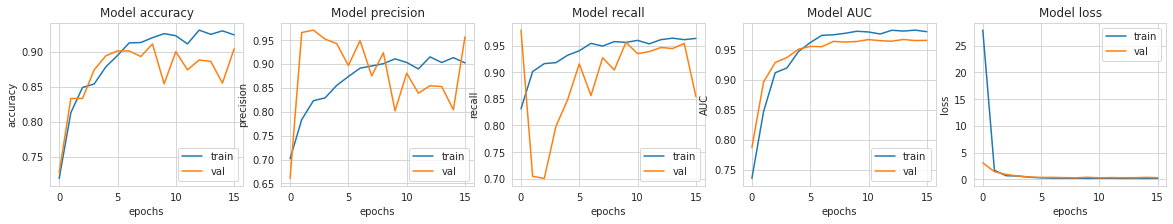

In [46]:
# Evaluate and display results
results = model_fcnn.evaluate(test_X_rgb, test_Y) # Evaluate the model on test data
results = dict(zip(model_fcnn.metrics_names,results))

print(results)
plottingScores(y_fcnn) # Visualise scores

**Building Model #2 - CNN
In our CNN model, fewer parameters are needed because every convolutional layer reduces the dimensions of the input through the convolution operation.**

In [47]:
def build_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding = 'valid', activation = 'relu', input_shape=(128, 128, 3)), #  convolutional layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)), # flatten output of conv
        
        tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding = 'valid', activation = 'relu'), #  convolutional layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)), # flatten output of conv
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'valid'),
        tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'valid'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(), # flatten output of conv
        tf.keras.layers.Dense(512, activation = "relu"), # hidden layer
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation = "relu"), #  output layer
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation = "sigmoid")])
    
    return model

In [48]:
# Build and compile model
model_cnn = build_cnn_model()
model_cnn.summary()
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 128)      

In [49]:
# Fit model
y_cnn = model_cnn.fit(train_X_rgb, 
                      train_Y,  
                      epochs=30, 
                      validation_split = 0.15, 
                      batch_size=128,
                      class_weight=classWeight,
                      callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
                      verbose=1) # Fit the model

Epoch 1/30
34/34 [==============================] - 39s 1s/step - loss: 0.3980 - accuracy: 0.8344 - precision: 0.8482 - recall: 0.9178 - AUC: 0.9403 - val_loss: 129.5963 - val_accuracy: 0.5213 - val_precision: 0.5213 - val_recall: 1.0000 - val_AUC: 0.5000
Epoch 2/30
34/34 [==============================] - 36s 1s/step - loss: 0.1997 - accuracy: 0.9144 - precision: 0.8977 - recall: 0.9488 - AUC: 0.9725 - val_loss: 27.1708 - val_accuracy: 0.5227 - val_precision: 0.5220 - val_recall: 1.0000 - val_AUC: 0.5028
Epoch 3/30
34/34 [==============================] - 36s 1s/step - loss: 0.1620 - accuracy: 0.9313 - precision: 0.9161 - recall: 0.9602 - AUC: 0.9816 - val_loss: 8.7587 - val_accuracy: 0.5240 - val_precision: 0.5227 - val_recall: 1.0000 - val_AUC: 0.5195
Epoch 4/30
34/34 [==============================] - 36s 1s/step - loss: 0.1442 - accuracy: 0.9428 - precision: 0.9319 - recall: 0.9641 - AUC: 0.9846 - val_loss: 0.2781 - val_accuracy: 0.9080 - val_precision: 0.8562 - val_recall: 0.9898

94/94 [==============================] - 8s 84ms/step - loss: 0.2649 - accuracy: 0.9027 - precision: 0.8512 - recall: 0.9932 - AUC: 0.9850
{'loss': 0.2648635804653168, 'accuracy': 0.9026666879653931, 'precision': 0.851165235042572, 'recall': 0.993201494216919, 'AUC': 0.9850112795829773}


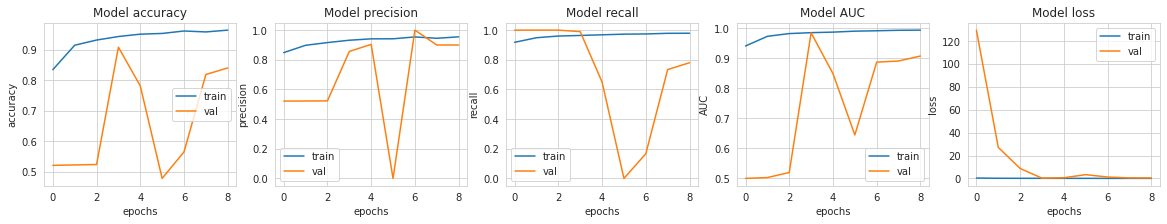

In [50]:
# Evalute the models results and put into a dict
results = model_cnn.evaluate(test_X_rgb, test_Y)
results = dict(zip(model_cnn.metrics_names,results))

print(results)
plottingScores(y_cnn) # Visualise scores

**Function to Perform K-Fold CV**

In [51]:
def performCV(K, build_model_func, epochs, batchSize):
    
    kfold = KFold(n_splits = K, shuffle = True) # Split data into K Folds
    
    res = {
        'acc_per_fold': [],
        'precision_per_fold': [],
        'recall_per_fold': [],
        'auc_per_fold': [],
        'loss_per_fold': []
    }

    fold_no = 1

    for train_index, test_index in kfold.split(train_X_rgb):

        X_train, X_test = train_X_rgb[train_index], train_X_rgb[test_index] # Split data
        y_train, y_test = train_Y[train_index], train_Y[test_index]

        model = build_model_func() # Build model
        mets = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='AUC')]

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=mets) # Compile our model

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        # Train the model on the current fold
        history = model.fit(X_train,
                            y_train, 
                            epochs = epochs,
                            batch_size = batchSize,
                            class_weight = classWeight,
                            callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler]) # Fit data to model

        scores = model.evaluate(X_test, y_test, verbose=0) # Evalute the model

        print(f'Scores for fold {fold_no}:')
        print(f'{model.metrics_names[0]}: {scores[0]}')
        print(f'{model.metrics_names[1]}: {scores[1]*100}%')
        print(f'{model.metrics_names[2]}: {scores[2]*100}%')
        print(f'{model.metrics_names[3]}: {scores[3]*100}%')

        res['loss_per_fold'].append(scores[0])
        res['acc_per_fold'].append(scores[1] * 100)
        res['precision_per_fold'].append(scores[2]*100)
        res['recall_per_fold'].append(scores[3]*100)
        res['auc_per_fold'].append(scores[4]*100)

        
        # Increase fold number
        fold_no += 1
    
    return res # return our results dict

In [52]:
#K-Fold Cross Validation with all 3 Networks

# Full-connected NN
resFCNN = performCV(5, build_fcnn_model, 30, 128)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
32/32 [==============================] - 3s 58ms/step - loss: 47.5643 - accuracy: 0.6085 - precision: 0.6043 - recall: 0.7640 - AUC: 0.6124
Epoch 2/30
32/32 [==============================] - 2s 53ms/step - loss: 3.1104 - accuracy: 0.7660 - precision: 0.7396 - recall: 0.8641 - AUC: 0.7946
Epoch 3/30
32/32 [==============================] - 2s 53ms/step - loss: 0.8751 - accuracy: 0.8465 - precision: 0.8221 - recall: 0.9079 - AUC: 0.9020
Epoch 4/30
32/32 [==============================] - 2s 52ms/step - loss: 0.4142 - accuracy: 0.8658 - precision: 0.8369 - recall: 0.9285 - AUC: 0.9416
Epoch 5/30
32/32 [==============================] - 2s 52ms/step - loss: 0.9089 - accuracy: 0.8240 - precision: 0.7958 - recall: 0.8999 - AUC: 0.8682
Epoch 6/30
32/32 [==============================] - 2s 52ms/step - loss: 0.8564 - accuracy: 0.8158 - precision: 0.7903 - recall: 0.8895 - AUC: 0.8792
Ep